In [ ]:
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from snowflake.ml.registry import Registry
from snowflake.snowpark import Session
from snowflake.snowpark.context import get_active_session
from xgboost import XGBClassifier

from common import get_next_model_version

try:
    session = get_active_session()
except:
    session = Session.builder.create()

DB = "DEMO"
SCHEMA = "PUBLIC"
COMPUTE_WAREHOUSE = "DEMO_WH"
model_name = "MORTGAGE_LENDING_MLOPS"

session.use_database(DB)
session.use_schema(SCHEMA)
session.use_warehouse(COMPUTE_WAREHOUSE)

In [17]:
try:
    print("Reading table data...")
    df = session.table(f"{DB}.{SCHEMA}.MORTGAGE_LENDING_DEMO_DATA").to_pandas()
    print(df.head())
except:
    print("Table not found! Uploading data to snowflake table")
    df_pandas = pd.read_csv("MORTGAGE_LENDING_DEMO_DATA.csv.zip")
    session.write_pandas(
        df_pandas, table_name="MORTGAGE_LENDING_DEMO_DATA",database= DB,schema=SCHEMA, auto_create_table=True
    )
    df = session.table(f"{DB}.{SCHEMA}.MORTGAGE_LENDING_DEMO_DATA").to_pandas()
    print(df.head())

Reading table data...
Table not found! Uploading data to snowflake table
   LOAN_ID                       TS LOAN_TYPE_NAME LOAN_PURPOSE_NAME  \
0   225846  2024-08-09 23:51:21.600  VA-guaranteed       Refinancing   
1   298793  2024-02-15 10:42:48.960  VA-guaranteed       Refinancing   
2   456295  2024-05-17 06:29:48.480   Conventional     Home purchase   
3   376334  2024-06-21 11:55:14.880    FHA-insured       Refinancing   
4   216409  2024-10-03 17:14:38.400   Conventional       Refinancing   

   APPLICANT_INCOME_000S  LOAN_AMOUNT_000S         COUNTY_NAME  \
0                    NaN               160         Erie County   
1                  109.0               255         Erie County   
2                  283.0               392  Westchester County   
3                   43.0               173       Albany County   
4                  209.0               255        Kings County   

   MORTGAGERESPONSE  
0                 1  
1                 1  
2                 1  
3        

In [18]:
df_ohe = pd.get_dummies(
    df, columns=["LOAN_TYPE_NAME", "LOAN_PURPOSE_NAME"], drop_first=True
)

# Convert all boolean columns to integers
df_ohe = df_ohe.apply(lambda x: x.astype(int) if x.dtype == "bool" else x)
df_ohe.columns = [re.sub(r"[^a-zA-Z0-9]+", "_", col.upper()) for col in df_ohe.columns]

df_ohe = df_ohe.dropna(subset=["APPLICANT_INCOME_000S"])
df_ohe.head()

,LOAN_ID,TS,APPLICANT_INCOME_000S,LOAN_AMOUNT_000S,COUNTY_NAME,MORTGAGERESPONSE,LOAN_TYPE_NAME_FHA_INSURED,LOAN_TYPE_NAME_FSA_RHS_GUARANTEED,LOAN_TYPE_NAME_VA_GUARANTEED,LOAN_PURPOSE_NAME_HOME_PURCHASE,LOAN_PURPOSE_NAME_REFINANCING
1,298793,2024-02-15 10:42:48.960,109.0,255,Erie County,1,0,0,1,0,1
2,456295,2024-05-17 06:29:48.480,283.0,392,Westchester County,1,0,0,0,1,0
3,376334,2024-06-21 11:55:14.880,43.0,173,Albany County,0,1,0,0,0,1
4,216409,2024-10-03 17:14:38.400,209.0,255,Kings County,1,0,0,0,0,1
5,423048,2024-05-19 11:34:04.800,95.0,120,Albany County,1,1,0,0,1,0


In [19]:
x = df_ohe.drop(["MORTGAGERESPONSE", "LOAN_ID", "TS", "COUNTY_NAME"], axis=1)
y = df_ohe.MORTGAGERESPONSE

xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, train_size=0.70, random_state=1234
)

# Model params
xgb_base = XGBClassifier(
    max_depth=50, n_estimators=3, learning_rate=0.75, booster="gbtree"
)

# Fit model
xgb_base.fit(xtrain, ytrain)

,objective,'binary:logistic'
,base_score,None
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [20]:
y_pred_train = xgb_base.predict(xtrain)
y_pred_proba_train = xgb_base.predict_proba(xtrain)[:, 1]

accuracy = accuracy_score(ytrain, y_pred_train)
precision = precision_score(ytrain, y_pred_train, average="weighted")
recall = recall_score(ytrain, y_pred_train, average="weighted")
f1 = f1_score(ytrain, y_pred_train, average="weighted")

metrics_train = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
}

y_pred = xgb_base.predict(xtest)
y_pred_proba = xgb_base.predict_proba(xtest)[:, 1]

accuracy = accuracy_score(ytest, y_pred)
precision = precision_score(ytest, y_pred, average="weighted")
recall = recall_score(ytest, y_pred, average="weighted")
f1 = f1_score(ytest, y_pred, average="weighted")

metrics_test = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
}
print(metrics_train)
print(metrics_test)

{'Accuracy': 0.8258453909565564, 'Precision': 0.8145177462799043, 'Recall': 0.8258453909565564, 'F1 Score': 0.8042272767780518}
{'Accuracy': 0.7606097715468096, 'Precision': 0.7233247195112333, 'Recall': 0.7606097715468096, 'F1 Score': 0.7305868026408117}


In [21]:
sample_data = x.sample(n=1)

reg = Registry(session=session, database_name=DB, schema_name=SCHEMA)
df = reg.show_models()
next_version = get_next_model_version(df, model_name)
print(next_version)

mortgage_model = reg.log_model(
    model_name=model_name,
    version_name=next_version,
    model=xgb_base,
    sample_input_data=sample_data,
    metrics=metrics_test,
    target_platforms=["WAREHOUSE"],
    conda_dependencies=["xgboost==3.0.1"],
    options={"relax_version": True},
)

V_1
Model logged successfully.: 100%|██████████| 6/6 [00:23<00:00,  3.94s/it]                          



ROC AUC Score: 0.6753

Confusion Matrix:


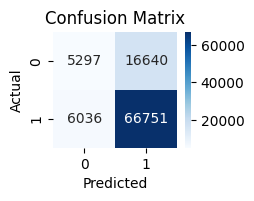

In [22]:
print(f"\nROC AUC Score: {roc_auc_score(ytest, y_pred_proba):.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(ytest, y_pred)
plt.figure(figsize=(2, 1.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [23]:
session.write_pandas(
    xtest, "MORTGAGE_TEST", database=DB, schema=SCHEMA, auto_create_table=True
)

/Users/cromano/Documents/Snow_DS_Training/Machine_Learning_Training/.venv/lib/python3.10/site-packages/snowflake/snowpark/session.py:3456: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.base.Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, _, _, ci_output = write_pandas(


In [24]:
m = reg.get_model(model_name)
recent_model_name = reg.get_model(model_name).last().version_name
m.default = recent_model_name
m.default

ModelVersion(
  name='MORTGAGE_LENDING_MLOPS',
  version='V_1',
)

In [25]:
sql_predict = session.sql(
    f"""
    select *, round({DB}.{SCHEMA}.MORTGAGE_LENDING_MLOPS!predict_proba(
    APPLICANT_INCOME_000S,
    LOAN_AMOUNT_000S,
    LOAN_TYPE_NAME_FHA_INSURED,
    LOAN_TYPE_NAME_FSA_RHS_GUARANTEED,
    LOAN_TYPE_NAME_VA_GUARANTEED,
    LOAN_PURPOSE_NAME_HOME_PURCHASE,
    LOAN_PURPOSE_NAME_REFINANCING
):output_feature_0,2)
as pred_response
from {DB}.{SCHEMA}.MORTGAGE_TEST
"""
)

sql_predict.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"APPLICANT_INCOME_000S"  |"LOAN_AMOUNT_000S"  |"LOAN_TYPE_NAME_FHA_INSURED"  |"LOAN_TYPE_NAME_FSA_RHS_GUARANTEED"  |"LOAN_TYPE_NAME_VA_GUARANTEED"  |"LOAN_PURPOSE_NAME_HOME_PURCHASE"  |"LOAN_PURPOSE_NAME_REFINANCING"  |"PRED_RESPONSE"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|55.0                     |85                  |0                             |0                                    |1                               |0                                  |1                                |0.84             |
|80.0                     |173              